In [1]:
from stop_metrics import create_combined_metrics_stop_df
from trip_metrics import create_combined_metrics_trip_df
import matplotlib.pyplot as plt
import random
import plotly.express as px
import polars as pl
import pandas as pd


In [2]:
#loading data
ca_xwalk = pl.read_parquet('communities_stops.parquet')
ca_xwalk = ca_xwalk.select(['community','stpid']).rename({'stpid':'stop_id'})

actual_stops = pl.read_parquet('out/actual_stop_metrics_df.parquet')
schedule_stops = pl.read_parquet('out/schedule_stop_metrics_df.parquet')
actual_trips  = pl.read_parquet('out/actual_trip_metrics_df.parquet')
schedule_trips = pl.read_parquet('out/schedule_trip_metrics_df.parquet')

total_stops = create_combined_metrics_stop_df(actual_stops, schedule_stops)
total_stops = total_stops.join(ca_xwalk, on='stop_id', how = 'left', coalesce=True)

total_trips = create_combined_metrics_trip_df(actual_trips, schedule_trips)

In [3]:
def average_by(df:pd.DataFrame, grouping:str, period:str, metrics:list):
    """
    grouping helper function 
    """
    df = df[~df['rt'].isin(['5','169'])]
    if 'community' in df.columns:
        df = df[['rt','period','period_value', 'community']+metrics]
    else: 
        df = df[['rt','period','period_value']+metrics]
        
    if period == "one_value":
        by_period = df[df['period'] == 'dayofyear']
        by_period_grouped = by_period.groupby([grouping])[metrics].median().reset_index()
    else:
        by_period = actual_stops[actual_stops['period']== period]
        by_period_grouped = by_period.groupby([grouping,'period_value'])[metrics].median().reset_index()

    #convert to minutes
    for metric in metrics:
        if 'num_buses' not in metric:
            by_period_grouped[metric] = by_period_grouped[metric].dt.total_seconds()/60

    
    return by_period_grouped

In [4]:
# create a route level metrics tables
# missing num of buses, should do sum not median

# weirdness in schedule trip duration
metrics_stop = ['median_actual_time_till_next_bus','std_actual_time_till_next_bus','time_till_next_bus_delay',
                'median_schedule_num_buses', 'median_actual_num_buses']
avg_stops = average_by(total_stops.to_pandas(),'rt', "one_value", metrics_stop)
metrics_trip = ['median_actual_trip_duration', 'median_schedule_trip_duration']
avg_trips = average_by(total_trips.to_pandas(),'rt', "one_value", metrics_trip)
avg_trips['trip_delay'] = avg_trips['median_actual_trip_duration'] - avg_trips['median_schedule_trip_duration']
avg_stops['bus_excess'] = avg_stops['median_actual_num_buses'] - avg_stops['median_schedule_num_buses']
all_metrics_rts = avg_stops.join(avg_trips.set_index('rt'), on='rt')


In [5]:
all_metrics_rts

,rt,median_actual_time_till_next_bus,std_actual_time_till_next_bus,time_till_next_bus_delay,median_schedule_num_buses,median_actual_num_buses,bus_excess,median_actual_trip_duration,median_schedule_trip_duration,trip_delay
0,1,16.257100,143.245402,0.158607,25.0,22.0,-3.0,36.125968,739.404167,-703.278199
1,100,20.513614,144.671636,0.457127,20.0,18.5,-1.5,32.721497,31.500000,1.221497
2,103,17.370830,10.027596,0.028937,14.0,13.0,-1.0,31.559426,29.500000,2.059426
3,106,15.472709,66.772132,0.212486,22.0,20.5,-1.5,20.569868,18.000000,2.569868
4,108,17.877450,11.500120,0.026293,4.0,4.0,0.0,30.779882,25.000000,5.779882
...,...,...,...,...,...,...,...,...,...,...
115,96,20.932545,13.397507,0.056276,22.0,15.0,-7.0,27.183565,20.500000,6.683565
116,97,19.821526,80.633965,0.298770,40.0,35.5,-4.5,39.350395,1441.750000,-1402.399605
117,J14,13.158780,11.081761,-0.067069,45.5,12.0,-33.5,61.288212,1446.387500,-1385.099288
118,X49,9.959759,127.664828,0.503727,38.0,34.5,-3.5,95.611145,1440.000000,-1344.388855


In [6]:
# create a community area metrics tables
# idk what to do with num of buses
metrics_stop = ['median_actual_time_till_next_bus','std_actual_time_till_next_bus','time_till_next_bus_delay',
                'median_schedule_num_buses', 'median_actual_num_buses']

all_metrics_ca = average_by(total_stops.to_pandas(),'community', "one_value", metrics_stop)
all_metrics_ca['bus_excess'] = all_metrics_ca['median_actual_num_buses'] - all_metrics_ca['median_schedule_num_buses']


In [7]:
all_metrics_ca

,community,median_actual_time_till_next_bus,std_actual_time_till_next_bus,time_till_next_bus_delay,median_schedule_num_buses,median_actual_num_buses,bus_excess
0,ALBANY PARK,12.101495,13.939987,0.101888,17.0,18.5,1.5
1,ARCHER HEIGHTS,14.522237,8.852496,-0.242907,10.0,10.0,0.0
2,ARMOUR SQUARE,19.222924,9.485269,0.087827,15.0,14.0,-1.0
3,ASHBURN,11.441010,9.064638,0.028967,21.0,21.5,0.5
4,AUBURN GRESHAM,9.707169,8.262724,0.088522,20.5,18.5,-2.0
...,...,...,...,...,...,...,...
72,WEST LAWN,13.026825,7.000039,-0.020545,8.0,9.0,1.0
73,WEST PULLMAN,14.701001,68.465013,0.306232,33.0,29.0,-4.0
74,WEST RIDGE,17.743992,65.251187,0.008547,31.0,32.0,1.0
75,WEST TOWN,10.257857,8.105193,-0.288383,12.0,23.0,11.0


In [23]:
import plotly.express as px
test = all_metrics_ca.sort_values(by='median_actual_time_till_next_bus', ascending=False)
fig = px.bar(test, x='community', y='median_actual_time_till_next_bus')
fig.show()


In [23]:
import plotly.express as px
test = test.sort_values(by='diff', ascending=False)
fig = px.bar(test, x='rt', y='diff')
fig.show()


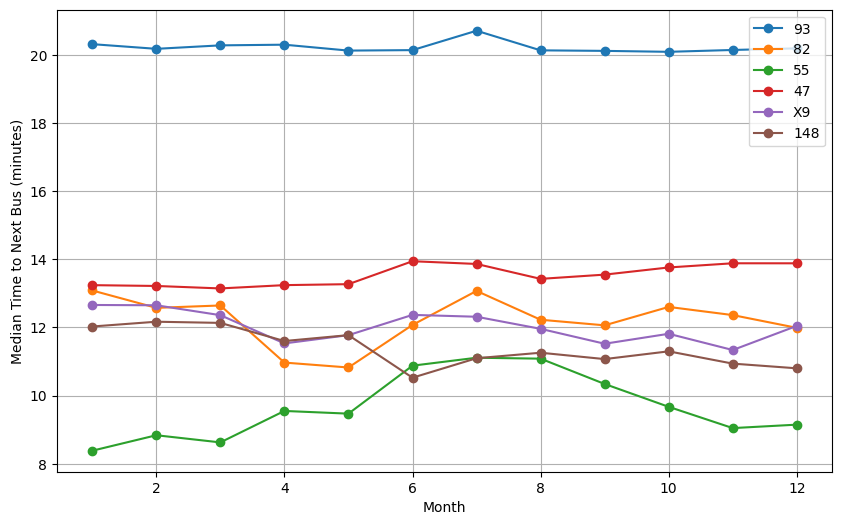

In [53]:
plt.figure(figsize=(10, 6))

rts = by_month_chart['rt'].unique().tolist()


# Plot a line for each route
for r in random.sample(rts, 6):
    subset = by_month_chart[by_month_chart['rt'] == r]
    plt.plot(subset['period_value'], subset['median_actual_time_till_next_bus'], marker='o', label=r)


plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Median Time to Next Bus (minutes)')
plt.legend()
plt.show()

In [13]:
actual_stops.groupby('rt')['median_actual_time_till_next_bus'].median().reset_index().sort_values('median_actual_time_till_next_bus').head()

,rt,median_actual_time_till_next_bus
84,66,0 days 00:06:33.249115978
97,79,0 days 00:06:34.571904927
95,77,0 days 00:07:54.990242953
26,152,0 days 00:08:57.799724587
37,20,0 days 00:08:59.832996777
